In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
import numpy as np
import os
import torch
import plotly.express as px
import pathlib

In [5]:
from smc01.postprocessing.util import find_checkpoint_file

In [4]:
DATA_DIR = pathlib.Path(os.getenv('DATA_DIR'))
model_path = DATA_DIR / 'runs/postprocessing/multirun/2023-01-25/11-18-52/5207216'

In [7]:
ckpt = torch.load(find_checkpoint_file(model_path), map_location=torch.device('cpu'))

In [13]:
biases = ckpt['state_dict']['model.biases']

In [14]:
biases.shape

torch.Size([1226, 730, 81, 1])

In [17]:
stations = pd.read_csv(DATA_DIR / 'interpolated/2021-12-20-gdps-metar/stations_w_metadata.csv')

In [19]:
stations[stations['station'] == 'CYUL']

,station,latitude,longitude,elevation
437,CYUL,45.4683,-73.7414,36.0


In [21]:
biases[437].shape

torch.Size([730, 81, 1])

In [33]:
timeseries = biases[437, :, 24].squeeze()

In [62]:
dfs = []
for step in [8, 32, 64]:
    df = pd.DataFrame({'bias': biases[437, :, step].squeeze(), 'dayofyear': np.arange(biases[437,:,step].shape[0])})
    df['step'] = step
    dfs.append(df)
    
df = pd.concat(dfs)
df['forecast_hour'] = df['dayofyear'].apply(lambda x: 0 if x % 2 == 0 else 12)
df['dayofyear'] = df['dayofyear'] // 2
df['step_hour'] = df['step'] * 3

In [63]:
df

,bias,dayofyear,step,forecast_hour,step_hour
0,-0.141710,0,8,0,24
1,-0.079248,0,8,12,24
2,-0.178017,1,8,0,24
3,-0.075639,1,8,12,24
4,-0.186595,2,8,0,24
...,...,...,...,...,...
725,-0.471692,362,64,12,192
726,-0.174193,363,64,0,192
727,-0.515452,363,64,12,192
728,-0.394324,364,64,0,192


In [86]:
df_subset = df[(df['forecast_hour'] == 0) & (df['step_hour'] == 192)]

In [87]:
padded_biases = pd.concat([df_subset.iloc[-30:], df_subset, df_subset.iloc[:30]])

In [104]:
padded_biases.reset_index()

,index,bias,dayofyear,step,forecast_hour,step_hour
0,670,-0.495422,335,64,0,192
1,672,-0.428091,336,64,0,192
2,674,-0.422413,337,64,0,192
3,676,-0.376597,338,64,0,192
4,678,-0.297357,339,64,0,192
...,...,...,...,...,...,...
420,50,-1.151576,25,64,0,192
421,52,-1.088730,26,64,0,192
422,54,-1.061673,27,64,0,192
423,56,-1.014259,28,64,0,192


In [89]:
rolled = padded_biases['bias'].rolling(window=60, center=True).mean()

In [91]:
rolled

670   NaN
672   NaN
674   NaN
676   NaN
678   NaN
       ..
50    NaN
52    NaN
54    NaN
56    NaN
58    NaN
Name: bias, Length: 425, dtype: float64

In [102]:
rolled.loc[4]

4   -0.605275
4         NaN
Name: bias, dtype: float64

In [107]:
padded_biases['rolled'] = rolled

In [109]:
padded_biases

,bias,dayofyear,step,forecast_hour,step_hour,rollded,rolled
670,-0.495422,335,64,0,192,NaN,NaN
672,-0.428091,336,64,0,192,NaN,NaN
674,-0.422413,337,64,0,192,NaN,NaN
676,-0.376597,338,64,0,192,NaN,NaN
678,-0.297357,339,64,0,192,NaN,NaN
...,...,...,...,...,...,...,...
50,-1.151576,25,64,0,192,NaN,NaN
52,-1.088730,26,64,0,192,NaN,NaN
54,-1.061673,27,64,0,192,NaN,NaN
56,-1.014259,28,64,0,192,NaN,NaN


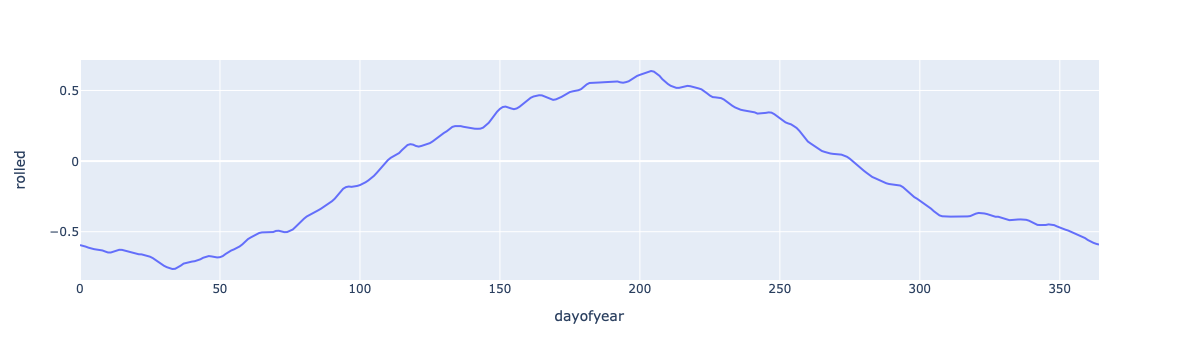

In [113]:
px.line(data_frame = padded_biases.iloc[30:-30], y='rolled', x='dayofyear')

In [119]:
unfiltered = df[(df['forecast_hour'] ==0) & (df['step_hour'] == 192)]

0     -0.594644
2     -0.598768
4     -0.605275
6     -0.612797
8     -0.619639
         ...   
720   -0.558626
722   -0.570033
724   -0.578681
726   -0.585793
728   -0.591119
Name: rolled, Length: 365, dtype: float64

In [127]:
unfiltered['rolled'] = padded_biases['rolled'].iloc[30:-30]

<ipython-input-127-7bf3686c3138>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [130]:
for_plot = unfiltered.melt(id_vars=['dayofyear'], value_vars=['bias', 'rolled'])

In [135]:
for_plot['filter'] = for_plot['variable'].map({'bias': 'No', 'rolled': 'Yes'})

In [142]:
for_plot

,dayofyear,variable,value,filter
0,0,bias,-0.388593,No
1,1,bias,-0.490336,No
2,2,bias,-0.544786,No
3,3,bias,-0.649112,No
4,4,bias,-0.861096,No
...,...,...,...,...
725,360,rolled,-0.558626,Yes
726,361,rolled,-0.570033,Yes
727,362,rolled,-0.578681,Yes
728,363,rolled,-0.585793,Yes


In [145]:
fig = px.line(data_frame=for_plot, x='dayofyear', y='value', color='filter',
        title='Bias term of MOS post-processing<br>Station CYUL<br>Step 192h', 
        labels={
            'value': 'Bias Term (°C)',
            'dayofyear': 'Day of year',
            'filter': '60 days Filtering',
        },
       width=800)



In [146]:
fig.write_image('bias_cyul.png')